In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

from joblib import dump, load

import shap
import lime
from sklearn.model_selection import train_test_split



In [2]:
file_path = '/Users/ameeshi/Desktop/fyp/data/FX_FanU_new.xlsx'
df = pd.read_excel(file_path)
df['DATE'] = pd.to_datetime(df['DATE'])

df_sg = df.drop(columns = ['CAD', 'KRONA', 'YEN', 'EURO', 'POUND', 'FRANC'])

df_sg['DATE'] = df_sg['DATE'].astype(str)
df_sg['DATE'] = df_sg['DATE'].str.split(' ').str[0]
df_sg.rename(columns={'DATE': 'Date'}, inplace=True)

df_sg.reset_index(drop = True)
# df_sg.to_csv("fx_filtered_sg.csv", index=False)

df_sg_train = df_sg[(df_sg['Date'] >= '2017-12-25') & (df_sg['Date'] <= '2018-12-31')]
df_sg_test = df_sg[(df_sg['Date'] >= '2020-01-01')]

In [3]:
df_sg_train

,Date,SGD
516,2017-12-25,1.34425
517,2017-12-26,1.34345
518,2017-12-27,1.33920
519,2017-12-28,1.33755
520,2017-12-29,1.33640
...,...,...
777,2018-12-25,1.37250
778,2018-12-26,1.37090
779,2018-12-27,1.37105
780,2018-12-28,1.36595


In [4]:
# List of currencies
currencies = ['SGD']

# Dictionary to store cumulative accuracies
cumulative_accuracies = {}

In [5]:
# Function to create lag features
def create_lag_features(df, lag=5):
    df_new = pd.DataFrame(index=df.index)
    for i in range(lag+1):
        if i == 0:
            df_new[f'{currencies}_t'] = df[currencies].values
        else:
            df_new[f'{currencies}_t-{i}'] = df[currencies].shift(i).values
    df_new.dropna(inplace=True)
    return df_new

In [6]:
lag = 5  # You can adjust this
train_df_lagged = create_lag_features(df_sg_train, lag=lag)
test_df_lagged = create_lag_features(df_sg_test, lag=lag)

In [7]:
train_df_lagged

,['SGD']_t,['SGD']_t-1,['SGD']_t-2,['SGD']_t-3,['SGD']_t-4,['SGD']_t-5
521,1.33640,1.33640,1.33755,1.33920,1.34345,1.34425
522,1.32920,1.33640,1.33640,1.33755,1.33920,1.34345
523,1.32925,1.32920,1.33640,1.33640,1.33755,1.33920
524,1.32830,1.32925,1.32920,1.33640,1.33640,1.33755
525,1.32730,1.32830,1.32925,1.32920,1.33640,1.33640
...,...,...,...,...,...,...
777,1.37250,1.37250,1.37220,1.37035,1.36905,1.37185
778,1.37090,1.37250,1.37250,1.37220,1.37035,1.36905
779,1.37105,1.37090,1.37250,1.37250,1.37220,1.37035
780,1.36595,1.37105,1.37090,1.37250,1.37250,1.37220


In [8]:
# Separating features and labels
X_train_fx = train_df_lagged.iloc[:, 1:].values  # All lag features
y_train_fx = train_df_lagged.iloc[:, 0].values  # Current value to predict

X_test_fx = test_df_lagged.iloc[:, 1:].values
y_test_fx = test_df_lagged.iloc[:, 0].values


# dates = create_dataset(df_sg_train)



In [9]:
# Extract and store the 'Date' column
dates = df_sg_train['Date']
test_dates = df_sg_test['Date']

In [10]:
# to match the rates prediction columns with the dates
dates = dates[5:]


In [11]:
# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust parameters
model.fit(X_train_fx, y_train_fx)

model_path = f'/Users/ameeshi/Desktop/fyp/joblibs/sg_model.joblib'  # Specify your path here
dump(model, model_path)

# Predicting for all dates in the dataset 
y_pred_train = model.predict(X_train_fx)

In [12]:
# Evaluating the model
train_error_mae = mean_absolute_error(y_train_fx, y_pred_train)
print(f"Train MAE: {train_error_mae}")

train_error_mse = mean_squared_error(y_train_fx, y_pred_train)
print(f"Train MSE: {train_error_mse}")

train_error_rmse = np.sqrt(train_error_mse)
print(f"Train RMSE: { train_error_rmse}")

train_r2 = r2_score(y_train_fx, y_pred_train)
print(f"Train r2 score: {train_r2}")


Train MAE: 0.0010867624521072223
Train MSE: 1.9578557337163592e-06
Train RMSE: 0.001399233981046901
Train r2 score: 0.996853280384229


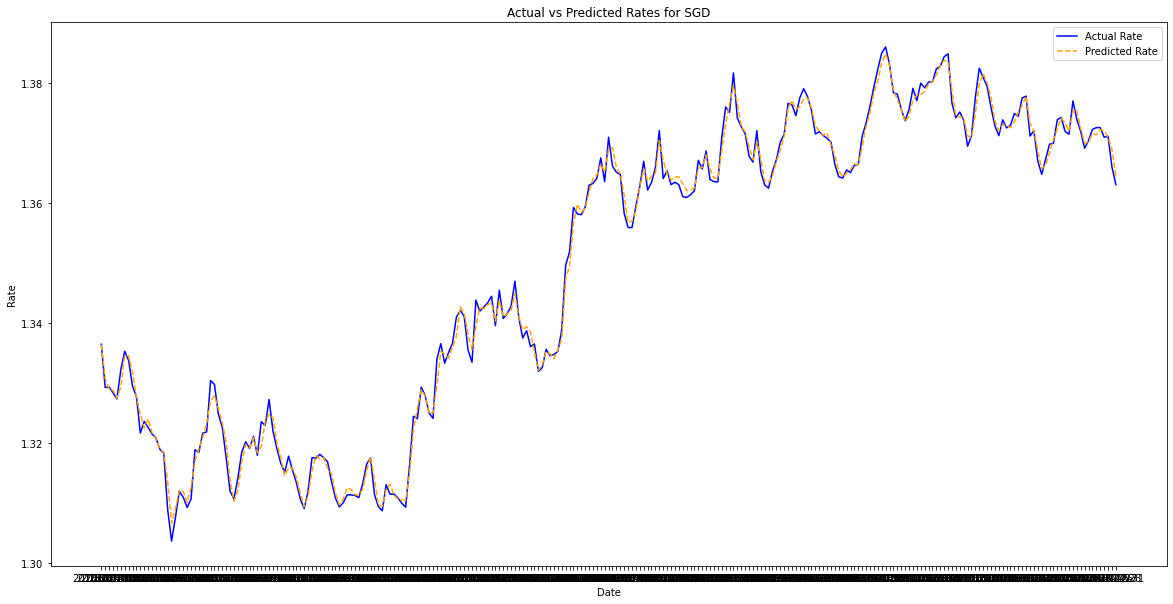

In [13]:
# for plot
plt.figure(figsize=(20,10))
plt.plot(dates, y_train_fx, label='Actual Rate', color='blue')
plt.plot(dates, y_pred_train, label='Predicted Rate', linestyle='--', color='orange')
plt.title(f'Actual vs Predicted Rates for SGD')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.show()
    

In [14]:
# for test dataset
y_pred_test = model.predict(X_test_fx)
test_error_mae = mean_absolute_error(y_test_fx, y_pred_test)
print(f"Test MAE: {test_error_mae}")

test_error_mse = mean_squared_error(y_test_fx, y_pred_test)
print(f"Test MSE: {test_error_mse}")

test_error_rmse = np.sqrt(test_error_mse)
print(f"Test RMSE: { test_error_rmse}")

test_r2 = r2_score(y_test_fx, y_pred_test)
print(f"Test r2 score: {test_r2}")

Test MAE: 0.008670475763016355
Test MSE: 0.00025466780918403345
Test RMSE: 0.015958314735085077
Test r2 score: 0.6933139147007541


In [15]:
# adjusting test dates to match the prediction rate correctly
adjusted_test_dates = test_dates[lag:] 
adjusted_test_dates = adjusted_test_dates[:len(y_pred_test)]

In [16]:
actual_with_dates = {date: actual for date, actual in zip(adjusted_test_dates, y_test_fx)}

# Printing the first few items to verify
for date, actual in list(actual_with_dates.items())[:5]:
    print(f"Date: {date}, Actual: {actual}")

Date: 2020-01-08, Actual: 1.35125
Date: 2020-01-09, Actual: 1.3521
Date: 2020-01-10, Actual: 1.3484
Date: 2020-01-13, Actual: 1.3467
Date: 2020-01-14, Actual: 1.34715


In [17]:
# Creating a dictionary to store predictions with their corresponding date
predictions_with_dates = {date: prediction for date, prediction in zip(adjusted_test_dates, y_pred_test)}

# Printing the first few items to verify
for date, prediction in list(predictions_with_dates.items())[:5]:
    print(f"Date: {date}, Prediction: {prediction}")

Date: 2020-01-08, Prediction: 1.3574530000000005
Date: 2020-01-09, Prediction: 1.3575715000000006
Date: 2020-01-10, Prediction: 1.3583760000000005
Date: 2020-01-13, Prediction: 1.3555975
Date: 2020-01-14, Prediction: 1.3458030000000005


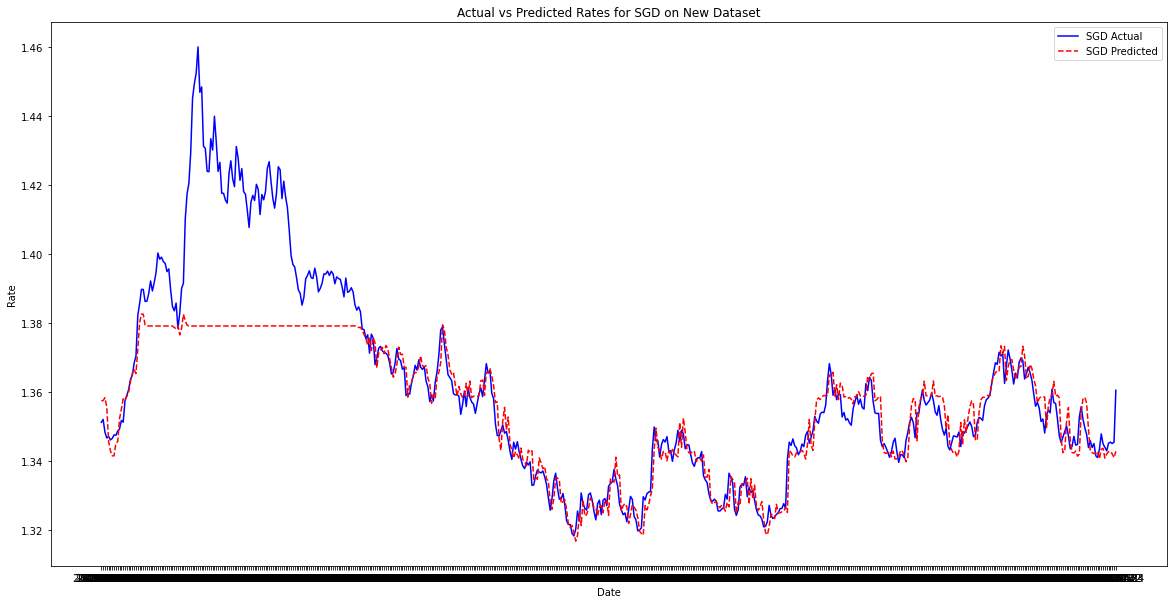

In [18]:
# Plotting the predicted rates
plt.figure(figsize=(20,10))
plt.plot(adjusted_test_dates, y_test_fx, label=f'SGD Actual', linestyle='-', color='blue')
plt.plot(adjusted_test_dates, y_pred_test, label=f'SGD Predicted', linestyle='--', color='red')

plt.title('Actual vs Predicted Rates for SGD on New Dataset')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend(loc='best')
plt.show()

In [19]:
dtypes = {'RegionName': str, 'RegionCode': str}
file_path_oxford = '/Users/ameeshi/Desktop/fyp/OxCGRT_nat_latest.xlsx'  # Update this path
df_oxford = pd.read_excel(file_path_oxford, dtype=dtypes)



In [20]:
df_oxford.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C1M_Flag,C2M_Workplace closing,C2M_Flag,...,MajorityVaccinated,PopulationVaccinated,StringencyIndex_Average,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex,EconomicSupportIndex_ForDisplay
0,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200101,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200102,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200103,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200104,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200105,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
interested_country = ['Singapore']
# Filter for Singapore
df_oxford_sg = df_oxford[df_oxford['CountryName'].isin(interested_country)]

# Change formatting of date
def convert_date(date):
    original_date = datetime.strptime(str(date), '%Y%m%d')
    formatted_date_str = original_date.strftime('%Y-%m-%d')
    return formatted_date_str

df_oxford_sg['Date'] = df_oxford_sg['Date'].apply(convert_date)

columns_to_drop = ["V1_Vaccine Prioritisation (summary)","V2A_Vaccine Availability (summary)","V2B_Vaccine age eligibility/availability age floor (general population summary)",
                   "V2C_Vaccine age eligibility/availability age floor (at risk summary)","V2D_Medically/ clinically vulnerable (Non-elderly)","V2E_Education",
                   "V2F_Frontline workers  (non healthcare)","V2G_Frontline workers  (healthcare)","V3_Vaccine Financial Support (summary)",
                   "V4_Mandatory Vaccination (summary)","ConfirmedDeaths","MajorityVaccinated","PopulationVaccinated",
                   "StringencyIndex_Average","GovernmentResponseIndex_Average","ContainmentHealthIndex_Average","EconomicSupportIndex",
                   "E1_Flag","H1_Flag","H7_Flag","C1M_Flag","C2M_Flag","C3M_Flag","C4M_Flag","C5M_Flag","C6M_Flag","C7M_Flag","H6M_Flag","H8M_Flag"]


# Select specified policy columns (N, R, T, etc. are placeholders for actual column names)
# coln_to_select = ['CURRENCY','CountryName','Date', 'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
#     'C4_Restrictions on gatherings', 'C5_Close public transport', 
#     'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
#     'C8_International travel controls', 'H1_Public information campaigns',
#     'H2_Testing policy', 'H3_Contact tracing', 'StringencyIndex', 'GovernmentResponseIndex']

# oxcg_filtered= df_oxford_sg[coln_to_select]

# Drop unwanted columns
oxcg_filtered = df_oxford_sg.drop(columns=columns_to_drop)




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
oxcg_filtered.head(3)

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,...,H5_Investment in vaccines,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,M1_Wildcard,ConfirmedCases,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex_ForDisplay
158979,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-01,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0,0.00,0.0
158980,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-02,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,13.89,9.9,11.31,0.0
158981,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-03,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,13.89,9.9,11.31,0.0


In [23]:

oxcg_filtered = oxcg_filtered[(oxcg_filtered['Date'] <= '2022-02-24')]

grouped = oxcg_filtered.groupby('CountryName')

# Fill missing values within each group
oxcg_filtered = grouped.apply(lambda group: group.fillna(method='bfill').fillna(method='ffill'))

# Reset the index to get a flat DataFrame
oxcg_filtered = oxcg_filtered.reset_index(drop=True)

In [24]:
oxcg_filtered.head(3)

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,...,H5_Investment in vaccines,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,M1_Wildcard,ConfirmedCases,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex_ForDisplay
0,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-01,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.00,0.0,0.00,0.0
1,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-02,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,13.89,9.9,11.31,0.0
2,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-03,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,13.89,9.9,11.31,0.0


In [25]:
country = {'SG': ['Singapore', 'SGD']}

In [26]:
oxcg_filtered['DailyChange'] = oxcg_filtered["ConfirmedCases"].diff()
oxcg_filtered['DailyChange'] = oxcg_filtered['DailyChange'].fillna(0)

oxcg_filtered.drop(columns = "ConfirmedCases", inplace = True)

In [27]:
# making a new dataframe for predicted rates and the dates for merging 
rates_df = pd.DataFrame(list(predictions_with_dates.items()), columns = ['Date', 'PredRate'])

In [28]:
actualrate_df = pd.DataFrame(list(actual_with_dates.items()), columns = ['Date', 'ActualRate'])

In [29]:
rates_df.head(3)


,Date,PredRate
0,2020-01-08,1.357453
1,2020-01-09,1.357572
2,2020-01-10,1.358376


In [30]:
actualrate_df.head(3)

,Date,ActualRate
0,2020-01-08,1.35125
1,2020-01-09,1.35210
2,2020-01-10,1.34840


In [31]:
merged_df = pd.merge(oxcg_filtered, rates_df, on='Date', how='inner')

In [32]:
merged_df

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,...,H6M_Facial Coverings,H7_Vaccination policy,H8M_Protection of elderly people,M1_Wildcard,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex_ForDisplay,DailyChange,PredRate
0,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-08,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,13.89,9.90,11.31,0.0,0.0,1.357453
1,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-09,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,13.89,9.90,11.31,0.0,0.0,1.357572
2,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-10,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,13.89,9.90,11.31,0.0,0.0,1.358376
3,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-13,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,13.89,9.90,11.31,0.0,0.0,1.355598
4,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-14,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,13.89,9.90,11.31,0.0,0.0,1.345803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,Singapore,SGP,NaN,NaN,NAT_TOTAL,2022-02-18,1.0,1.0,1.0,4.0,...,4.0,5.0,3.0,NaN,43.71,68.34,63.81,100.0,18094.0,1.342741
553,Singapore,SGP,NaN,NaN,NAT_TOTAL,2022-02-21,1.0,1.0,1.0,4.0,...,4.0,5.0,3.0,NaN,43.66,68.31,63.78,100.0,13623.0,1.342903
554,Singapore,SGP,NaN,NaN,NAT_TOTAL,2022-02-22,1.0,1.0,1.0,4.0,...,4.0,5.0,3.0,NaN,43.66,68.31,63.78,100.0,26032.0,1.342128
555,Singapore,SGP,NaN,NaN,NAT_TOTAL,2022-02-23,1.0,1.0,1.0,4.0,...,4.0,5.0,3.0,NaN,43.65,68.31,63.77,100.0,20312.0,1.341037


In [33]:
merged_df = pd.merge(merged_df, actualrate_df, on = 'Date', how = 'inner')

In [34]:
merged_df

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,...,H7_Vaccination policy,H8M_Protection of elderly people,M1_Wildcard,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex_ForDisplay,DailyChange,PredRate,ActualRate
0,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-08,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,13.89,9.90,11.31,0.0,0.0,1.357453,1.35125
1,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-09,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,13.89,9.90,11.31,0.0,0.0,1.357572,1.35210
2,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-10,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,13.89,9.90,11.31,0.0,0.0,1.358376,1.34840
3,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-13,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,13.89,9.90,11.31,0.0,0.0,1.355598,1.34670
4,Singapore,SGP,NaN,NaN,NAT_TOTAL,2020-01-14,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,13.89,9.90,11.31,0.0,0.0,1.345803,1.34715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,Singapore,SGP,NaN,NaN,NAT_TOTAL,2022-02-18,1.0,1.0,1.0,4.0,...,5.0,3.0,NaN,43.71,68.34,63.81,100.0,18094.0,1.342741,1.34520
553,Singapore,SGP,NaN,NaN,NAT_TOTAL,2022-02-21,1.0,1.0,1.0,4.0,...,5.0,3.0,NaN,43.66,68.31,63.78,100.0,13623.0,1.342903,1.34550
554,Singapore,SGP,NaN,NaN,NAT_TOTAL,2022-02-22,1.0,1.0,1.0,4.0,...,5.0,3.0,NaN,43.66,68.31,63.78,100.0,26032.0,1.342128,1.34510
555,Singapore,SGP,NaN,NaN,NAT_TOTAL,2022-02-23,1.0,1.0,1.0,4.0,...,5.0,3.0,NaN,43.65,68.31,63.77,100.0,20312.0,1.341037,1.34550


In [35]:
# train data
oxcg_filtered_train = merged_df[(merged_df['Date'] < '2021-01-01')]
oxcg_filtered_train = oxcg_filtered_train.reset_index(drop = True)

# test data
oxcg_filtered_test = merged_df[(merged_df['Date'] >= '2021-01-01')]
oxcg_filtered_test = oxcg_filtered_test.reset_index(drop = True)

In [36]:
oxcg_filtered_test

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,...,H7_Vaccination policy,H8M_Protection of elderly people,M1_Wildcard,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex_ForDisplay,DailyChange,PredRate,ActualRate
0,Singapore,SGP,NaN,NaN,NAT_TOTAL,2021-01-01,1.0,2.0,1.0,4.0,...,1.0,2.0,NaN,50.93,65.31,60.36,100.0,30.0,1.320768,1.32165
1,Singapore,SGP,NaN,NaN,NAT_TOTAL,2021-01-04,1.0,2.0,1.0,4.0,...,1.0,2.0,NaN,50.93,65.31,60.36,100.0,24.0,1.321372,1.31905
2,Singapore,SGP,NaN,NaN,NAT_TOTAL,2021-01-05,1.0,2.0,1.0,4.0,...,1.0,2.0,NaN,50.93,65.31,60.36,100.0,28.0,1.319339,1.31835
3,Singapore,SGP,NaN,NaN,NAT_TOTAL,2021-01-06,1.0,2.0,1.0,4.0,...,1.0,2.0,NaN,50.93,65.31,60.36,100.0,31.0,1.316848,1.32030
4,Singapore,SGP,NaN,NaN,NAT_TOTAL,2021-01-07,1.0,2.0,1.0,4.0,...,1.0,2.0,NaN,50.93,65.31,60.36,100.0,33.0,1.318544,1.32555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Singapore,SGP,NaN,NaN,NAT_TOTAL,2022-02-18,1.0,1.0,1.0,4.0,...,5.0,3.0,NaN,43.71,68.34,63.81,100.0,18094.0,1.342741,1.34520
296,Singapore,SGP,NaN,NaN,NAT_TOTAL,2022-02-21,1.0,1.0,1.0,4.0,...,5.0,3.0,NaN,43.66,68.31,63.78,100.0,13623.0,1.342903,1.34550
297,Singapore,SGP,NaN,NaN,NAT_TOTAL,2022-02-22,1.0,1.0,1.0,4.0,...,5.0,3.0,NaN,43.66,68.31,63.78,100.0,26032.0,1.342128,1.34510
298,Singapore,SGP,NaN,NaN,NAT_TOTAL,2022-02-23,1.0,1.0,1.0,4.0,...,5.0,3.0,NaN,43.65,68.31,63.77,100.0,20312.0,1.341037,1.34550


In [37]:
oxcg_test_dates = oxcg_filtered_test['Date']

In [38]:
oxcg_filtered_test.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1M_School closing', 'C2M_Workplace closing',
       'C3M_Cancel public events', 'C4M_Restrictions on gatherings',
       'C5M_Close public transport', 'C6M_Stay at home requirements',
       'C7M_Restrictions on internal movement',
       'C8EV_International travel controls', 'E1_Income support',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6M_Facial Coverings', 'H7_Vaccination policy',
       'H8M_Protection of elderly people', 'M1_Wildcard',
       'StringencyIndex_Average_ForDisplay',
       'GovernmentResponseIndex_Average_ForDisplay',
       'ContainmentHealthIndex_Average_ForDisplay',
       'EconomicSupportIndex_ForDisplay', 'DailyChange', 'PredRate',
       'ActualRate

In [39]:
# Select relevant features (COVID-19 policy data) and the target variable (exchange rate)
features_to_select = ['C1M_School closing', 'C2M_Workplace closing', 'C3M_Cancel public events', 'C4M_Restrictions on gatherings', \
            'C5M_Close public transport', 'C6M_Stay at home requirements', 'C7M_Restrictions on internal movement', \
            'C8EV_International travel controls', 'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', \
            'E4_International support', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', \
            'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'H6M_Facial Coverings', 'H7_Vaccination policy', \
            'H8M_Protection of elderly people', 'DailyChange', 'StringencyIndex_Average_ForDisplay',
       'GovernmentResponseIndex_Average_ForDisplay',]

# fx_rate = predictions_with_dates.get("Prediction")

In [40]:
X_train_oxcg = oxcg_filtered_train[features_to_select]
y_train_oxcg = oxcg_filtered_train['PredRate']

X_test_oxcg = oxcg_filtered_test[features_to_select]
y_test_oxcg = oxcg_filtered_test["PredRate"]
y_test_act = oxcg_filtered_test['ActualRate']

In [41]:
oxcg_model = RandomForestRegressor(n_estimators=100, random_state=42)
oxcg_model.fit(X_train_oxcg, y_train_oxcg)

RandomForestRegressor(random_state=42)

In [42]:
# predicting revised rate 
y_pred = oxcg_model.predict(X_test_oxcg)


In [43]:
mae = mean_absolute_error(y_test_act, y_test_oxcg)
print(f"Mean Absolute Error: {mae}")

mse = mean_squared_error(y_test_act, y_test_oxcg)
print(f"Mean Squared Error: {mse}")

rmse = np.sqrt(mse)
print(f" RMSE: { rmse}")

r2 = r2_score(y_test_act, y_test_oxcg)
print(f"r2 score: {r2}")

Mean Absolute Error: 0.00353722333333334
Mean Squared Error: 2.068071930166671e-05
 RMSE: 0.004547605886800956
r2 score: 0.8802131160153129


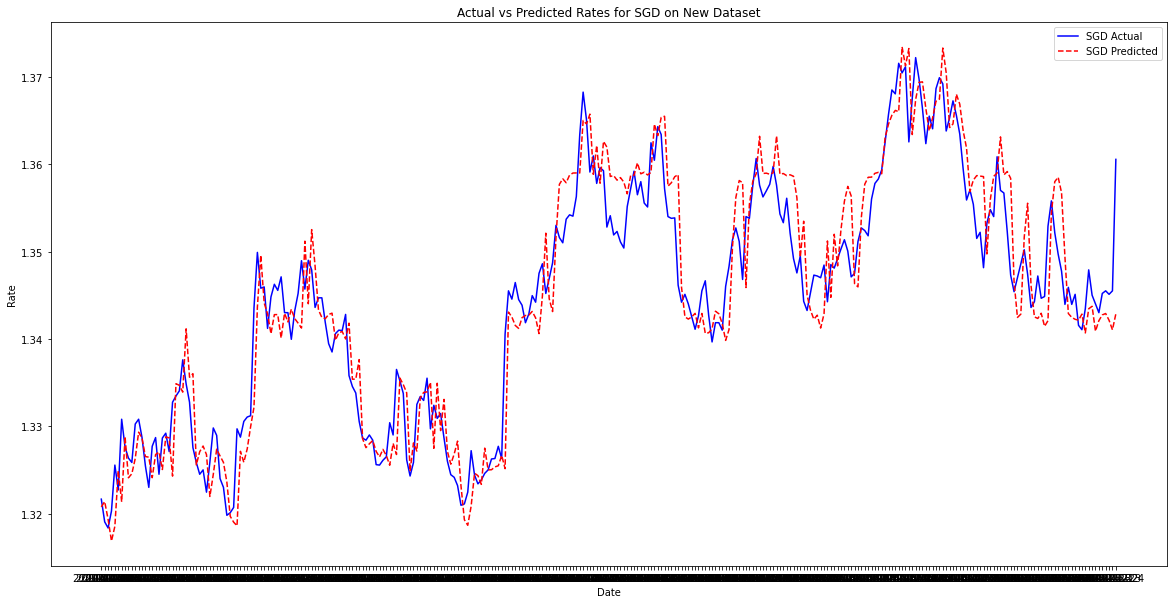

In [44]:
# Plotting the predicted rates
plt.figure(figsize=(20,10))
plt.plot(oxcg_test_dates, y_test_act, label=f'SGD Actual', linestyle='-', color='blue')
plt.plot(oxcg_test_dates, y_test_oxcg, label=f'SGD Predicted', linestyle='--', color='red')

plt.title('Actual vs Predicted Rates for SGD on New Dataset')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend(loc='best')
plt.show()

In [45]:
# Initialize the SHAP Explainer
explainer = shap.Explainer(oxcg_model, X_train_oxcg)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_oxcg)

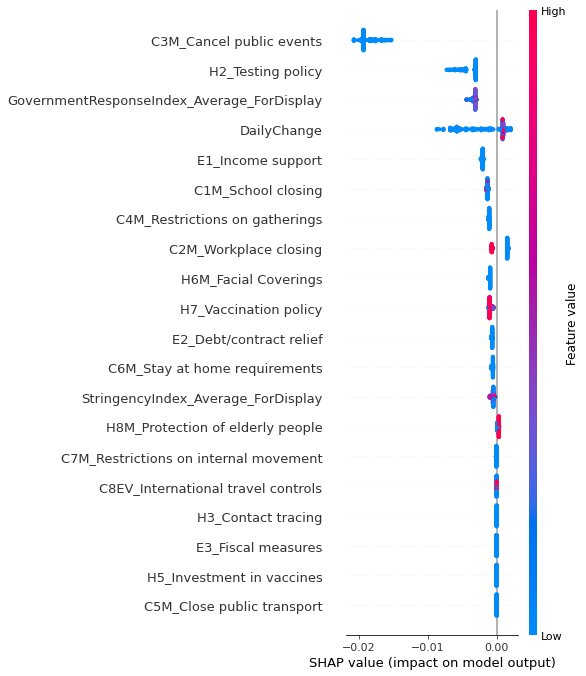

In [46]:
shap.summary_plot(shap_values, X_test_oxcg)

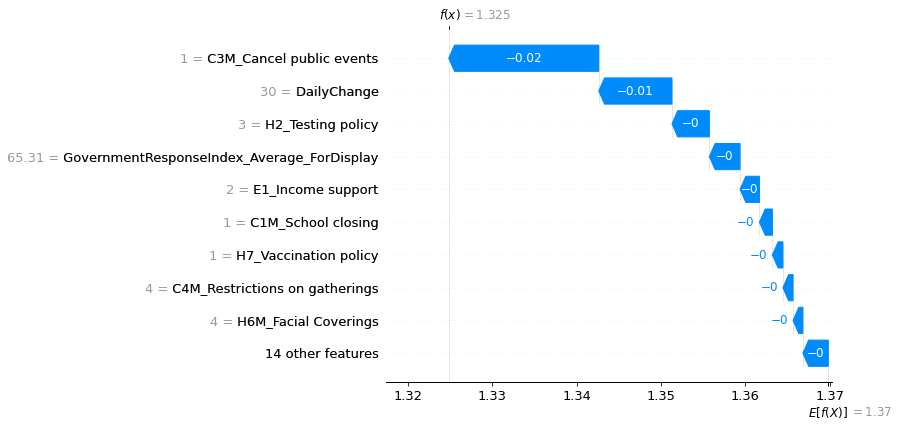

In [47]:
shap.plots.waterfall(shap_values[0])

In [48]:
from lime import lime_tabular

In [49]:
X_train_oxcg_df = pd.DataFrame(X_train_oxcg, columns=features_to_select)

# Initialize the LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_oxcg_df.values,
    feature_names=features_to_select,
    mode='regression'
)

In [50]:
instance_idx = 0  # For example, explaining the first instance in the test set
instance = X_test_oxcg.iloc[instance_idx].values

# Generate the LIME explanation
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=oxcg_model.predict
)

# Display the explanation
# For Jupyter notebooks:
exp.show_in_notebook(show_table=True, show_all=False)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [51]:
importances = oxcg_model.feature_importances_


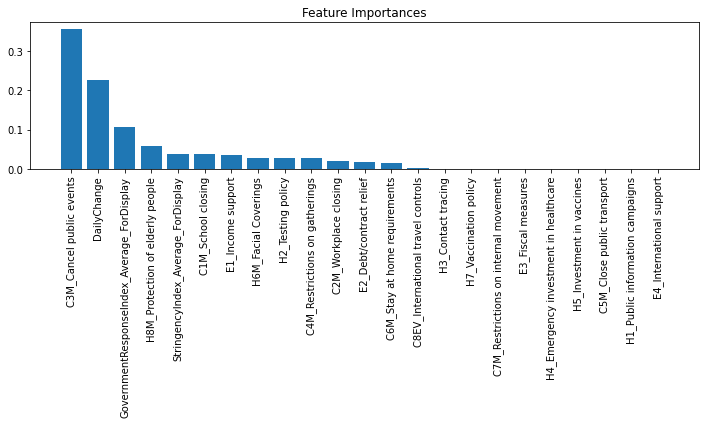

In [52]:
feature_names = X_test_oxcg.columns

# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train_oxcg.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X_train_oxcg.shape[1]), np.array(feature_names)[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


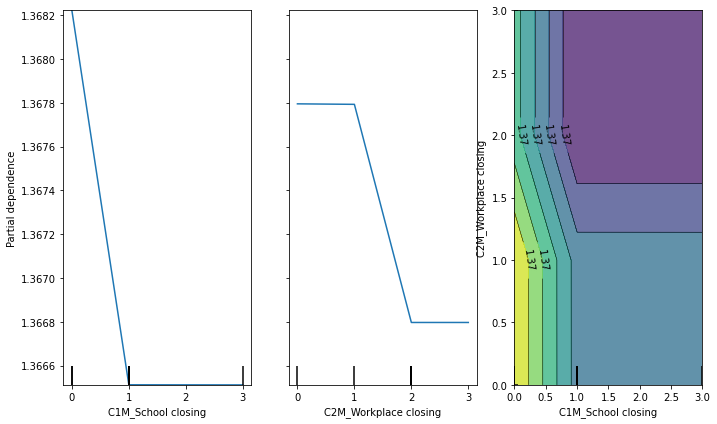

In [53]:
from sklearn.inspection import plot_partial_dependence

fig, ax = plt.subplots(figsize=(10, 6))
plot_partial_dependence(oxcg_model, X_train_oxcg, features=[0, 1, (0, 1)], feature_names=feature_names, ax=ax)
plt.tight_layout()
plt.show()

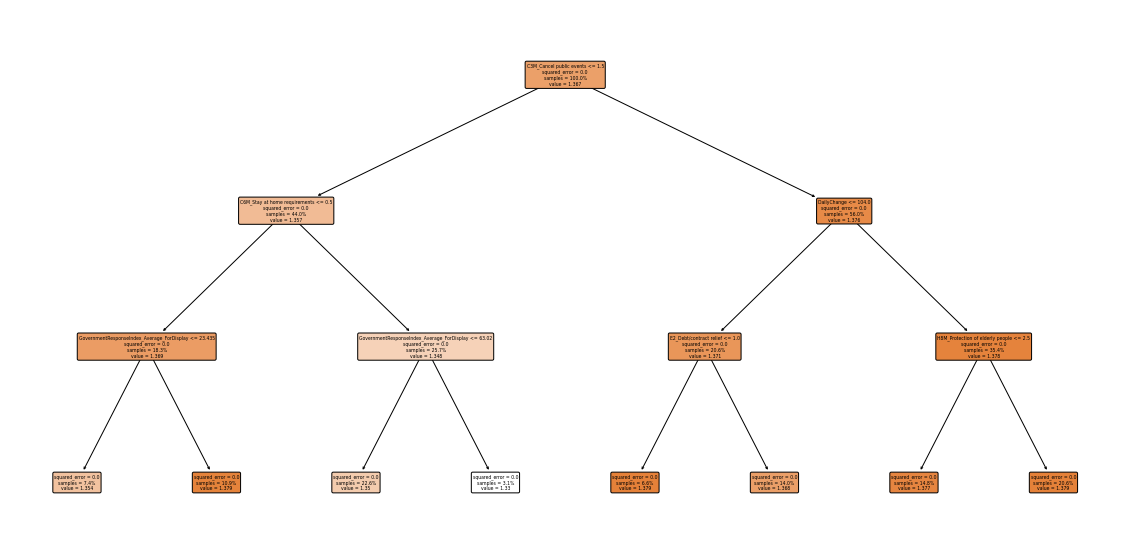

In [54]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Train a surrogate decision tree
surrogate = DecisionTreeRegressor(max_depth=3)
surrogate.fit(X_train_oxcg, oxcg_model.predict(X_train_oxcg))

plt.figure(figsize=(20,10))
plot_tree(surrogate, filled=True, feature_names=feature_names, proportion=True, rounded=True)
plt.show()